In [15]:
import numpy as np
from numpy import ndarray

import scipy
from scipy import ndimage
from scipy import misc
from scipy import fftpack
import proc_funs

import matplotlib.pyplot as plt


%matplotlib inline

In [16]:
quant_DCT= np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                     [12, 12, 14, 19, 26, 58, 60, 55],
                     [14, 13, 16, 24, 40, 57, 69, 56],
                     [14, 17, 22, 29, 51, 87, 80, 62],
                     [18, 22, 37, 56, 68,109,103, 77],
                     [24, 35, 55, 64, 81,104,113, 92],
                     [49, 64, 78, 87,103,121,120,101],
                     [72, 92, 95, 98,112,100,103, 99]])

In [17]:
def rgb2YCbCr(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    Y = 0.299*R + 0.587*G + 0.114*B
    Cb = 128*np.ones(R.shape) - 0.168736*R - 0.331264*G + 0.5*B
    Cr = 128*np.ones(R.shape) + 0.5*R -0.418688*G - 0.081312*B
    channels = [Y, Cb, Cr]
    img_YCbCr = np.stack(channels, axis = 2)
    return img_YCbCr

In [18]:
def YCbCr2rgb(img):
    Y = img[:,:,0]
    Cb = img[:,:,1]
    Cr = img[:,:,2]
    R = Y + 1.402*(Cr-128)
    G = Y - 0.344136*(Cb - 128*np.ones(Cb.shape)) - 0.714136*(Cr - 128*np.ones(Cr.shape))
    B = Y + 1.772*(Cb-128*np.ones(Cb.shape))
    channels = [R, G, B]
    img_RGB = np.stack(channels, axis = 2)
    return img_RGB

In [19]:
def EE123_psnr(ref, meas, maxVal=255):
    assert np.shape(ref) == np.shape(meas), "Test image must match measured image dimensions"
        
    
    dif = (ref.astype(float)-meas.astype(float)).ravel()
    mse = np.linalg.norm(dif)**2/np.prod(np.shape(ref))
    psnr = 10*np.log10(maxVal**2.0/mse)
    return psnr

In [20]:
# def down_samp(img, dim_0_n=1, dim_1_n=1, interp = cv.INTER_AREA):
#     curr_shape = img.shape
#     new_shape_col_maj = (curr_shape[1]//dim_1_n, curr_shape[0]//dim_0_n)
#     down_samp_img = cv.resize(img, new_shape_col_maj)
#     return down_samp_img
def down_samp(img, dim_0_n=1, dim_1_n=1):
    return img[::dim_0_n, ::dim_1_n]

In [21]:
# def up_samp(img, shape, interp = cv.INTER_CUBIC):
#     col_maj_shape = (shape[1], shape[0])
#     up_samp_img = cv.resize(img, col_maj_shape)
#     return up_samp_img

In [22]:
def adjust_quant_mat(Q = 50):
    if Q == 50:
        return quant_DCT
    elif (Q < 50):
        S = 5000/Q
    else:
        S = 200 - 2*Q
    adjust_quant_mat = np.floor((S*quant_DCT + 50*np.ones(quant_DCT.shape))/100)
    return adjust_quant_mat

In [23]:
def quantize_jpeg_dct(channels, Q=50):
    # Channels must be a multiple of 8 in each dim
    quant_block = adjust_quant_mat(Q)
    for i in range(len(channels)):
        dim_0, dim_1 = channels[i].shape
        assert dim_0 % 8 == 0 and dim_1 % 8 == 0
        num_reps_0 = dim_0//8
        num_reps_1 = dim_1//8
        quant_mat = np.tile(quant_block, (num_reps_0, num_reps_1))
        channels[i] = np.divide(channels[i], quant_mat)
        channels[i] = np.around(channels[i])
        channels[i].astype(dtype=np.uint8)
    return channels

In [24]:
def dequantize_jpeg_dct(channels, Q=50):
    quant_block = adjust_quant_mat(Q)
    for i in range(len(channels)):
        dim_0, dim_1 = channels[i].shape
        assert dim_0 % 8 == 0 and dim_1 % 8 == 0
        num_reps_0 = dim_0//8
        num_reps_1 = dim_1//8
        quant_mat = np.tile(quant_block, (num_reps_0, num_reps_1))
        channels[i] = np.multiply(channels[i], quant_mat)   
    return channels

In [25]:
def jpeg_comp_dct(img, Q=50, ds_chroma_0 = 2, ds_chroma_1 = 1):
    #convert to YCbCr
    img_shape = img.shape
    img_ycbcr = rgb2YCbCr(img)
    channels = [img_ycbcr[:,:,0], img_ycbcr[:,:,1], img_ycbcr[:,:,2]]
    #channels = [img_ycbcr[:,:,0], down_samp(img_ycbcr[:,:,1], ds_chroma_0, ds_chroma_1), down_samp(img_ycbcr[:,:,2], ds_chroma_0, ds_chroma_1)]
    for i in range(len(channels)):
        curr_shape = channels[i].shape
        rem_dim_0 = curr_shape[0] % 8
        rem_dim_1 = curr_shape[1] % 8
        if rem_dim_0 != 0:
            num_new_rows = 8 - rem_dim_0
            new_rows = np.tile(channels[i][-1,:], (num_new_rows, 1))
            channels[i] = np.concatenate([channels[i], new_rows], 0)
        if rem_dim_1 != 0:
            num_new_cols = 8 - rem_dim_1
            new_cols = np.tile(np.reshape(channels[i][:,-1],(channels[i].shape[0],1)), (1, num_new_cols))
            channels[i] = np.concatenate([channels[i], new_cols], 1)  
    #perform DCT on 8x8 blocks
    for chn_ind in range(len(channels)):
        curr_channel = channels[chn_ind]
        for i in range(0, curr_channel.shape[0], 8):
            for j in range(0, curr_channel.shape[1], 8):
                curr_channel[i:i+8,j:j+8] = fftpack.dct(fftpack.dct(curr_channel[i:i+8,j:j+8], axis=0, norm='ortho'), axis=1, norm='ortho')
    #clip image to prevent integer rollover
    #Quantize dct components
    channels = quantize_jpeg_dct(channels, Q=Q)
    for chn_ind in range(len(channels)):
        channels[chn_ind] = np.clip(channels[chn_ind], 0, 255)   
    
    return channels
    

In [53]:
def jpeg_decomp_dct(channels, img_shape, Q=50, ds_chroma_0 = 2, ds_chroma_1 = 1):
    #reverse quantization
    channels = dequantize_jpeg_dct(channels, Q=Q)
    for chn_ind in range(len(channels)):
        curr_channel = channels[chn_ind]
        for i in range(0, curr_channel.shape[0], 8):
            for j in range(0, curr_channel.shape[1], 8):
                curr_channel[i:i+8,j:j+8] = fftpack.idct(fftpack.idct(curr_channel[i:i+8,j:j+8], axis=0, norm='ortho'), axis=1, norm='ortho')    
    for chn_ind in range(len(channels)):
        #For the lumanince channel we need the original img_shape
        if chn_ind == 0:
            channels[chn_ind] = channels[chn_ind][:img_shape[0],:img_shape[1]]
        #otherwise we need to take how many downsampled samples we had
        else:
            dim_0_samps = img_shape[0] #//ds_chroma_0
            dim_1_samps = img_shape[1] #//ds_chroma_1
            channels[chn_ind] = channels[chn_ind][:dim_0_samps,:dim_1_samps]            
            
    # interpolate chroma channels back to original size
    #for chn_ind in range(1,len(channels)):      
    #    channels[chn_ind] = up_samp(channels[chn_ind], (img_shape[0], img_shape[1]))
    ycbcr_img = np.stack(channels, axis = 2)
    rgb_img = YCbCr2rgb(ycbcr_img)
    rgb_img = np.around(rgb_img)
    rgb_img = rgb_img.astype(np.uint8)
    return rgb_img

    

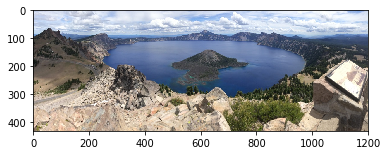

In [56]:
test_im_f_name = 'createrLake.tiff'
test_img = scipy.ndimage.imread(test_im_f_name)
plt.figure()
plt.imshow(test_img)

In [57]:
channels_jpeg = jpeg_comp_dct(test_img, Q=80, ds_chroma_0 = 4, ds_chroma_1 = 2)
print(np.shape(channels_jpeg))

(3, 432, 1200)


In [58]:
rec_img = jpeg_decomp_dct(channels_jpeg, test_img.shape, Q=80, ds_chroma_0 = 4, ds_chroma_1 = 2)

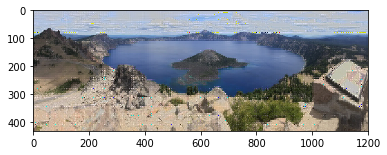

In [59]:
plt.figure()
plt.imshow(rec_img)

In [38]:
print(np.shape(rec_img))

(432, 1200, 3)


In [60]:
EE123_psnr(test_img, rec_img)

21.263291981600304

### Testing bytes to chanel and back

In [1]:
im_name = 'createrlake.tiff'
color_compress, color_decompress = color_proc()
bitties, shapes = color_compress(im_name)

NameError: name 'test_img' is not defined

In [835]:
rec_channels = bytes_to_channels(byte_str, shapes)


In [836]:
rec_img = np.stack(rec_channels, axis=2)

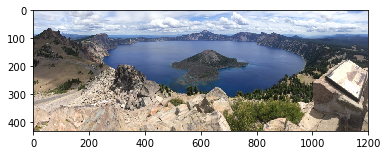

In [837]:
plt.figure()
plt.imshow(rec_img)

In [880]:
def jepeg_back_forth(img, Q=90, ds_chroma_0 = 2, ds_chroma_1 = 1):
    #forward
    img_shape = img.shape
    img_ycbcr = rgb2YCbCr(img)
    channels = [img_ycbcr[:,:,0], down_samp(img_ycbcr[:,:,1], ds_chroma_0, ds_chroma_1), down_samp(img_ycbcr[:,:,2], ds_chroma_0, ds_chroma_1)]
    for i in range(len(channels)):
        curr_shape = channels[i].shape
        rem_dim_0 = curr_shape[0] % 8
        rem_dim_1 = curr_shape[1] % 8
        if rem_dim_0 != 0:
            num_new_rows = 8 - rem_dim_0
            new_rows = np.tile(channels[i][-1,:], (num_new_rows, 1))
            channels[i] = np.concatenate([channels[i], new_rows], 0)
        if rem_dim_1 != 0:
            num_new_cols = 8 - rem_dim_1
            new_cols = np.tile(np.reshape(channels[i][:,-1],(channels[i].shape[0],1)), (1, num_new_cols))
            channels[i] = np.concatenate([channels[i], new_cols], 1)
    #center coefficients   
    
    #perform DCT on 8x8 blocks
    for chn_ind in range(len(channels)):
        curr_channel = channels[chn_ind]
        for i in range(0, curr_channel.shape[0], 8):
            for j in range(0, curr_channel.shape[1], 8):
                curr_channel[i:i+8,j:j+8] = fftpack.dct(fftpack.dct(curr_channel[i:i+8,j:j+8], axis=0, norm='ortho'), axis=1, norm='ortho')
    #clip image to prevent integer rollover
    #Quantize dct components
    channels = quantize_jpeg_dct(channels, Q=Q)
    for chn_ind in range(len(channels)):
        channels[chn_ind] = np.clip(channels[chn_ind], 0, 255)   
#     #backwards
    channels = dequantize_jpeg_dct(channels, Q=Q)
    for chn_ind in range(len(channels)):
        curr_channel = channels[chn_ind]
        for i in range(0, curr_channel.shape[0], 8):
            for j in range(0, curr_channel.shape[1], 8):
                curr_channel[i:i+8,j:j+8] = fftpack.idct(fftpack.idct(curr_channel[i:i+8,j:j+8], axis=0, norm='ortho'), axis=1, norm='ortho')    
    for chn_ind in range(len(channels)):
        #For the lumanince channel we need the original img_shape
        if chn_ind == 0:
            channels[chn_ind] = channels[chn_ind][:img_shape[0],:img_shape[1]]
        #otherwise we need to take how many downsampled samples we had
        else:
            dim_0_samps = img_shape[0]//ds_chroma_0
            dim_1_samps = img_shape[1]//ds_chroma_1
            channels[chn_ind] = channels[chn_ind][:dim_0_samps,:dim_1_samps]            
            
    # interpolate chroma channels back to original size
    for chn_ind in range(1,len(channels)):      
        channels[chn_ind] = up_samp(channels[chn_ind], (img_shape[0], img_shape[1]))
    ycbcr_img = np.stack(channels, axis = 2)
    rgb_img = YCbCr2rgb(ycbcr_img)
    rgb_img = np.around(rgb_img)
    rgb_img = rgb_img.astype(np.uint8)
    return rgb_img

In [881]:
new_img = jepeg_back_forth(test_img, 80, 4, 4)

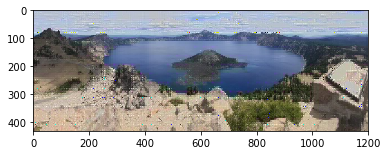

In [882]:
plt.figure()
plt.imshow(new_img)

In [876]:
EE123_psnr(test_img, new_img)

21.319808431463333

In [773]:
jpeg_channels = jpeg_comp_dct(test_img)